In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#torch.manual_seed(42)

In [3]:
def logistic_ode(t, y, r=0.1, K=10):
    return r * y * (1 - y / K)

In [4]:
def generate_logistic_dataset(num_trajectories=100, t_span=[0, 10], dt=0.1):
    t_eval = np.arange(t_span[0], t_span[1], dt)
    X_list, y_list = [], []

    for _ in range(num_trajectories):
        y0 = np.random.uniform(0.1, 5.0)
        sol = solve_ivp(logistic_ode, t_span, [y0], t_eval=t_eval, args=(0.1, 10))
        traj = sol.y[0]  # shape: (len(t_eval),)

        # Create pairs (y(t), y(t+dt))
        for i in range(len(traj) - 1):
            X_list.append([traj[i]])
            y_list.append([traj[i+1]])

    X = torch.tensor(X_list, dtype=torch.float32)
    y = torch.tensor(y_list, dtype=torch.float32)
    return X.to(device), y.to(device)

X_train, y_train = generate_logistic_dataset(num_trajectories=100)
X_test, y_test = generate_logistic_dataset(num_trajectories=20)
print(X_train.cpu().shape, y_train.cpu().shape)
print(X_test.cpu().shape, y_test.cpu().shape)

torch.Size([9900, 1]) torch.Size([9900, 1])
torch.Size([1980, 1]) torch.Size([1980, 1])


In [5]:
#class ToyModel(nn.Module):
#    def __init__(self):
#        super().__init__()
#        self.fc1 = nn.Linear(1, 4)
#        self.fc2 = nn.Linear(4, 1)
#
#    def forward(self, x, params=None):
#        if params is None:
#            return self.fc2(torch.tanh(self.fc1(x)))
#        else:
#            x = F.linear(x, params['fc1.weight'], params['fc1.bias'])
#            x = torch.tanh(x)
#            x = F.linear(x, params['fc2.weight'], params['fc2.bias'])
#            return x

In [6]:
class ODEPredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 16)   # a bit wider hidden layer for ODE
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x, params=None):
        if params is None:
            x = F.linear(x, self.fc1.weight, self.fc1.bias)
            x = torch.tanh(x)
            x = F.linear(x, self.fc2.weight, self.fc2.bias)
        else:
            x = F.linear(x, params['fc1.weight'], params['fc1.bias'])
            x = torch.tanh(x)
            x = F.linear(x, params['fc2.weight'], params['fc2.bias'])
        return x

In [7]:
class ScalarWiseLSTMOptimizer(nn.Module):
    def __init__(self, hidden_size=10):
        super().__init__()
        self.lstm = nn.LSTMCell(1, hidden_size)
        self.linear = nn.Linear(hidden_size, 1)
        self.hidden_size = hidden_size

    def forward(self, grad_input, state):
        h, c = self.lstm(grad_input, state)
        delta = self.linear(h)

        # Add activation + scale to control step size
        scaled_delta = 0.1 * torch.tanh(delta)

        return scaled_delta, (h, c)


In [8]:
def meta_train_l2o(optimizer_net, meta_iters=200, unroll_steps=10):
    meta_optim = torch.optim.Adam(optimizer_net.parameters(), lr=1e-3)

    for meta_iter in range(meta_iters):
        model = ODEPredictor().to(device)
        param_dict = {name: p.clone().requires_grad_(True) for name, p in model.named_parameters()}

        # Init hidden states
        states = {
            name: [
                (
                    torch.zeros(1, optimizer_net.hidden_size, device=device),
                    torch.zeros(1, optimizer_net.hidden_size, device=device)
                ) for _ in p.view(-1)
            ]
            for name, p in param_dict.items()
        }

        losses = []
        for step in range(unroll_steps):
            # Forward pass
            y_pred = model(X_train, param_dict)
            loss = F.mse_loss(y_pred, y_train)
            losses.append(loss)

            # Compute gradients w.r.t. current parameters
            grads = torch.autograd.grad(loss, param_dict.values(), create_graph=True)

            # Apply learned optimizer update per scalar param
            new_param_dict = {}
            for (name, p), g in zip(param_dict.items(), grads):
                flat_p = p.view(-1)
                flat_g = g.view(-1)
                updated_flat = []

                for i in range(len(flat_p)):
                    grad_i = flat_g[i].unsqueeze(0).unsqueeze(0)  # shape [1, 1]
                    h_i, c_i = states[name][i]
                    h_i = h_i.detach()
                    c_i = c_i.detach()

                    delta, (h_new, c_new) = optimizer_net(grad_i, (h_i, c_i))

                    # DEBUG: ensure delta depends on optimizer_net
                    assert delta.requires_grad, "delta must require grad!"

                    updated_flat.append((flat_p[i] - delta.squeeze(0)))
                    states[name][i] = (h_new, c_new)

                new_p = torch.stack(updated_flat).view_as(p)
                new_param_dict[name] = new_p

            # Prepare for next unroll step
            param_dict = {k: v.clone().requires_grad_(True) for k, v in new_param_dict.items()}

        # Meta-optimization step
        meta_loss = losses[-1]  # only last-step loss
        meta_optim.zero_grad()
        meta_loss.backward()
        meta_optim.step()

        if meta_iter % 10 == 0:
            print(f"[{meta_iter}] Meta-loss: {meta_loss.item():.6f}")


In [9]:
optimizer_net = ScalarWiseLSTMOptimizer().to(device)
meta_train_l2o(optimizer_net)

[0] Meta-loss: 25.370157
[10] Meta-loss: 15.812302
[20] Meta-loss: 12.066708
[30] Meta-loss: 11.048346
[40] Meta-loss: 7.785262
[50] Meta-loss: 2.687047
[60] Meta-loss: 2.714801
[70] Meta-loss: 1.327328
[80] Meta-loss: 1.531000
[90] Meta-loss: 1.642604
[100] Meta-loss: 1.108204
[110] Meta-loss: 1.125583
[120] Meta-loss: 2.014748
[130] Meta-loss: 2.040652
[140] Meta-loss: 1.508212
[150] Meta-loss: 1.522499
[160] Meta-loss: 1.747388
[170] Meta-loss: 1.210196
[180] Meta-loss: 1.159284
[190] Meta-loss: 1.537615


In [10]:
def evaluate_optimizer(optimizer_net, steps=100):
    model = ODEPredictor().to(device)
    param_dict = {k: v.clone().detach().requires_grad_(True) for k, v in model.named_parameters()}

    # Initialize hidden states per scalar parameter
    states = {
        k: [
            (
                torch.zeros(1, optimizer_net.hidden_size).to(device),
                torch.zeros(1, optimizer_net.hidden_size).to(device)
            ) for _ in v.view(-1)
        ]
        for k, v in param_dict.items()
    }

    losses_l2o = []

    for step in range(steps):
        pred = model(X_test, param_dict)
        loss = F.mse_loss(pred, y_test)
        losses_l2o.append(loss.item())

        grads = torch.autograd.grad(loss, param_dict.values())

        new_params = {}
        for (name, p), g in zip(param_dict.items(), grads):
            flat_p = p.view(-1)
            flat_g = g.view(-1)
            updated_flat = []

            for i in range(len(flat_p)):
                grad_i = flat_g[i].view(1, 1)
                h_i, c_i = states[name][i]
                delta, (h_new, c_new) = optimizer_net(grad_i, (h_i, c_i))
                updated_val = flat_p[i] - delta.squeeze(0)
                updated_flat.append(updated_val)
                states[name][i] = (h_new, c_new)

            new_p = torch.stack(updated_flat).view_as(p)
            new_params[name] = new_p

        param_dict = {k: v.clone().detach().requires_grad_(True) for k, v in new_params.items()}

    return losses_l2o

In [11]:
def evaluate_adam(steps=100):
    model = ODEPredictor().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    losses_adam = []
    for step in range(steps):
        pred = model(X_test)
        loss = F.mse_loss(pred, y_test)
        losses_adam.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return losses_adam

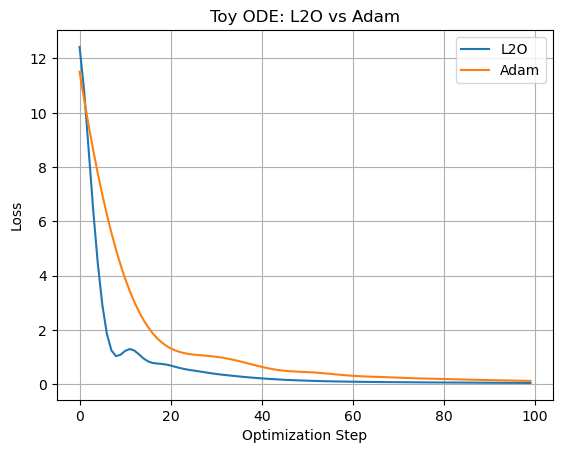

In [12]:
l2o_losses = evaluate_optimizer(optimizer_net)
adam_losses = evaluate_adam()

plt.plot(l2o_losses, label="L2O")
plt.plot(adam_losses, label="Adam")
plt.xlabel("Optimization Step")
plt.ylabel("Loss")
plt.title("Toy ODE: L2O vs Adam")
plt.legend()
plt.grid(True)
plt.show()